# Evaluation on synthetic data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from lib import pipeline
from lib import data_gen
import importlib
importlib.reload(pipeline)
from mlreflect.models import DefaultTrainedModel, TrainedModel
from mlreflect.data_generation import ReflectivityGenerator
from mlreflect.training import InputPreprocessor, OutputPreprocessor
import tensorflow as tf
from tensorflow import keras
from mlreflect.curve_fitter import CurveFitter
from mlreflect.data_generation import interp_reflectivity
test_number_of_curves = 10240

test_values_per_curve = 109
PARAMETERS = ["Film_thickness", "Film_roughness", "Film_sld"]
plt.close('all')

In [2]:
noise_level=0.2
BATCH_SIZE=512

In [3]:
model_cnn = keras.models.load_model(
    'models/current_state_models/0.001_0.2_100_100_50_12_8_512_20220705-194014')
# model_cnn=keras.models.load_model("models/current_state_models/0.0_800.0_25_50_100_10_8_6_512_20220714-124651")
mean_labels, std_labels = np.loadtxt(
    "data/mean_labels.csv"), np.loadtxt("data/std_labels.csv")
mean_data, std_data = np.loadtxt(
    f"data/mean_data_{noise_level}.csv"), np.loadtxt(f"data/std_data_{noise_level}.csv")

In [4]:
def predict_mlp_syn(gen_test, ip, out, data_test_true_real_scale):
    reflectivity_true_unit_scale = ip.standardize(data_test_true_real_scale)
    model = DefaultTrainedModel().keras_model
    pred_params_unit_scale = model.predict(reflectivity_true_unit_scale)
    pred_params_real_scale_full = out.restore_labels(pred_params_unit_scale)
    reflectivity_sim = gen_test.simulate_reflectivity(
        pred_params_real_scale_full)
    print(model.summary())
    return reflectivity_sim, pred_params_real_scale_full

In [5]:
def predict_cnn_syn(generator, reflectivity_true_real_scale, labels):

    reflectivity_true_real_scale = reflectivity_true_real_scale.reshape(
        test_number_of_curves, test_values_per_curve, 1)
    pred_params_true_scale_full = labels.copy()
    
    labels=labels.drop(labels.columns.difference(["Film_thickness", "Film_roughness", "Film_sld"]), axis=1)
    labels=labels.to_numpy()
    dataset=tf.data.Dataset.from_tensor_slices((reflectivity_true_real_scale, labels)).batch(BATCH_SIZE)
    pred_params_unit_scale = model_cnn.predict(dataset)
    pred_params_true_scale = pred_params_unit_scale*std_labels+mean_labels
    
    pred_params_true_scale_full["Film_thickness"] = pred_params_true_scale[:, 0]
    pred_params_true_scale_full["Film_roughness"] = pred_params_true_scale[:, 1]
    pred_params_true_scale_full["Film_sld"] = pred_params_true_scale[:, 2]
    reflectivity_sim = generator.simulate_reflectivity(
        pred_params_true_scale_full)
    print(model_cnn.summary())
    return reflectivity_sim, pred_params_true_scale_full

In [6]:
def make_analysis(reflectivity_true_real_scale, q_values, refl_sim_lst, params_cnn, params_mlp, labels):
    mse=tf.keras.losses.MeanSquaredError()
    error_lst = []
    fig_boxplot, axs_boxplot = plt.subplots(1, 2, sharey=True)
    fig_boxplots_param_errors, axs_boxplots_param_errors = plt.subplots(
        1, 3, figsize=(10, 5))
    fig_boxplots_param_errors_rel, axs_boxplots_param_errors_rel = plt.subplots(
        1, 3, figsize=(10, 5))
    fig, axs = plt.subplots(5, 5, figsize=(15, 10), sharex=True)
    fig.suptitle(
        "Ground truth vs. Predicted curves (simulations, no noise, pseudo test)")
    fig_boxplot.suptitle("Statistical comparison MSE Errors on Params")

    for idx, modelname in enumerate(["mlp", "cnn"]):
        for idx_lineplot, ax in enumerate(axs.flat):
            ax.semilogy(
                q_values, refl_sim_lst[idx][idx_lineplot], label=f"predicted_{modelname}")
        cnn_parameters=params_cnn[PARAMETERS].to_numpy()
        mlp_parameters=params_mlp[PARAMETERS].to_numpy()
        
        model_params=[cnn_parameters, mlp_parameters]
        labels_parameters=labels[PARAMETERS].to_numpy()
        error_lst = []
        error_dict={}
        for entry_pred, entry_labels in zip(model_params[idx], labels_parameters):
            entry_pred=(entry_pred-mean_labels)/std_labels
            entry_labels=(entry_labels-mean_labels)/std_labels
            error_lst.append(mse(entry_pred, entry_labels).numpy())
        error_dict[modelname]=error_lst
        axs_boxplot[idx].boxplot(error_dict[modelname], showfliers=False)
        axs_boxplot[idx].set_xticklabels([f"{modelname}"])

    for idx, (box, param) in enumerate(zip(axs_boxplots_param_errors, PARAMETERS)):
        box.boxplot([np.absolute(params_mlp[param]-labels[param]),
                    np.absolute(params_cnn[param]-labels[param])], showfliers=False)
        box.set_title(f"Absolute error: {param}")
        box.set_xticklabels(["MLP", "CNN"])

    for idx, (box, param) in enumerate(zip(axs_boxplots_param_errors_rel, PARAMETERS)):
        box.boxplot([100*np.absolute(params_mlp[param]-labels[param])/labels[param], 100 *
                    np.absolute(params_cnn[param]-labels[param])/labels[param]], showfliers=False)  # outliers?
        box.set_title(f"Relative error: {param}")
        box.set_xticklabels(["MLP", "CNN"])

    for idx, ax in enumerate(axs.flat):
        ax.semilogy(
            q_values, reflectivity_true_real_scale[idx], label="ground truth")
        ax.legend()
    fig.tight_layout()
    fig_boxplots_param_errors.tight_layout()


In [7]:
def visualize_comparison():
    q_values = DefaultTrainedModel().q_values
    sample = DefaultTrainedModel().sample
    generator = ReflectivityGenerator(q_values, sample)
    labels = generator.generate_random_labels(test_number_of_curves)
    ip = InputPreprocessor()
    out = OutputPreprocessor(sample)
    reflectivity_true_real_scale = generator.simulate_reflectivity(labels)
    refl_sim_lst = []
    reflectivity_sim_mlp, params_mlp = predict_mlp_syn(
        generator, ip, out, reflectivity_true_real_scale)
    refl_sim_lst.append(reflectivity_sim_mlp)

    reflectivity_sim_cnn, params_cnn = predict_cnn_syn(
        generator, reflectivity_true_real_scale, labels)
    refl_sim_lst.append(reflectivity_sim_cnn)

    make_analysis(reflectivity_true_real_scale, q_values,
                  refl_sim_lst, params_cnn, params_mlp, labels)

100%|██████████| 10240/10240 [00:01<00:00, 7490.76it/s]


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 500)               55000     
_________________________________________________________________
activation_9 (Activation)    (None, 500)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 500)               250500    
_________________________________________________________________
activation_10 (Activation)   (None, 500)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 500)               250500    
_________________________________________________________________
activation_11 (Activation)   (None, 500)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 3)                

100%|██████████| 10240/10240 [00:01<00:00, 5679.91it/s]


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
noise_and_standardize (noise multiple                  0         
_________________________________________________________________
input_2 (InputLayer)         [(None, 109, 1)]          0         
_________________________________________________________________
conv1d (Conv1D)              multiple                  1300      
_________________________________________________________________
max_pooling1d (MaxPooling1D) multiple                  0         
_________________________________________________________________
conv1d_1 (Conv1D)            multiple                  40050     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 multiple                  0         
_________________________________________________________________
flatten (Flatten)            multiple                  0

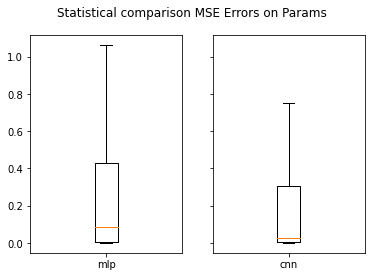

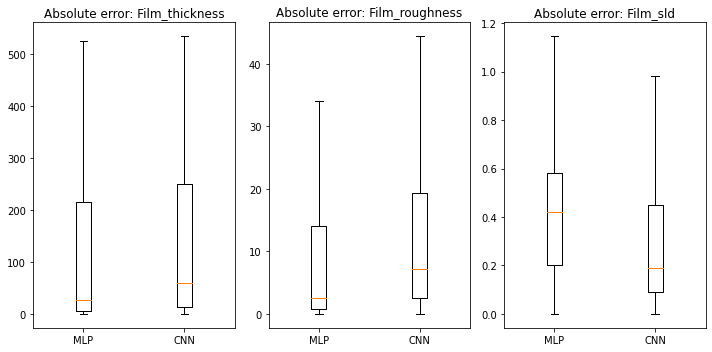

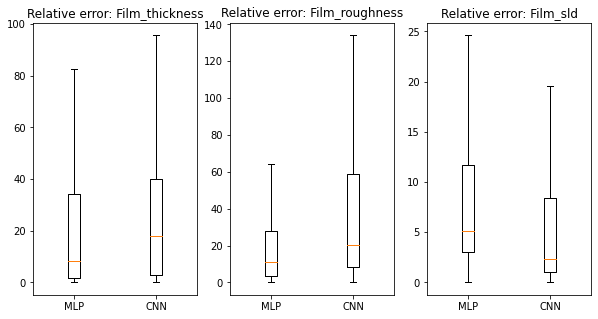

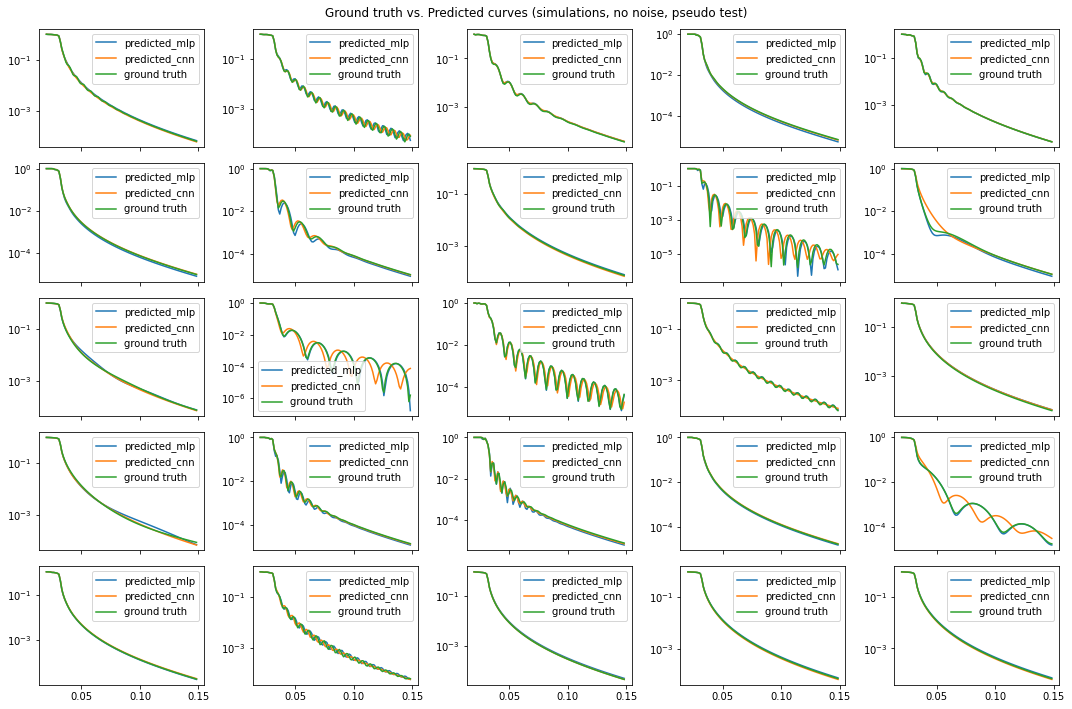

In [8]:
visualize_comparison()

In [9]:
plt.close('all')